# Conditional Self-Attention GAN for Facial Emoji Generation

Adapted from:
- [Build Basic Generative Adversarial Networks (GANs) Week 4 Programming Assignment](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans/programming/aFndv/conditional-gan)
- [Self-Attention GAN](https://github.com/heykeetae/Self-Attention-GAN)

### Packages and Visualization

In [1]:
import torch
import os
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from model import *

def set_all_seeds(seed):
#     random.seed(seed)
#     np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()
        
set_all_seeds(0)

### Noise

In [2]:
def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

### Class Input

In conditional GANs, the input vector for the generator will also need to include the class information. The class is represented using a one-hot encoded vector where its length is the number of classes and each index represents a class. The vector is all 0's and a 1 on the chosen class. 


In [3]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels, num_classes=n_classes)

Next, we need to be able to concatenate the one-hot class vector to the noise vector before giving it to the generator. We will also need to do this when adding the class channels to the discriminator.

In [4]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat((x.float(), y.float()), dim=1)
    return combined

### Parameters

*   image_shape: the number of pixels in each image. We further downsize every image to 64 x 64 to be compatible with the self-attention GAN architecture
*   n_classes: the number of classes (10, since there are 10 different emojis)
*   image_path: path to image folder
*   criterion: the loss function
*   n_epochs: the number of times to iterate through the entire dataset when training
*   z_dim: the dimension of the noise vector
*   display_step: how often to display/visualize the images
*   batch_size: the number of images per forward/backward pass
*   lr: the learning rate
*   device: the device type
*   g_conv_dim: the number of dimensions in the last convolutional layer of the generator
*   d_conv_dim: the number of dimensions in the first convolutional layer of the discriminator
*   ckpt_epoch: how often to save model checkpoint

In [5]:
image_shape = (3, 64, 64)
n_classes = 10
image_path = '../resized_emoji_challenge_128_faces'
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
g_conv_dim = 64
d_conv_dim = 64
ckpt_epoch = 5

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [6]:
transform = transforms.Compose([
    transforms.Resize((image_shape[1], image_shape[2])),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = ImageFolder(image_path, transform=transform)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

Then, we can initialize our generator, discriminator, and optimizers. To do this, we will need to update the input dimensions for both models. For the generator, we will need to calculate the size of the input vector; recall that for conditional GANs, the generator's input is the noise vector concatenated with the class vector. For the discriminator, we need to add a channel for every class.

In [7]:
def get_input_dimensions(z_dim, image_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        image_shape: the shape of each image as (C, W, H)
        n_classes: the total number of classes in the dataset, an integer scalar
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = image_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [8]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, image_shape, n_classes)

gen = Generator(image_shape[1], generator_input_dim, g_conv_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(discriminator_im_chan, d_conv_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        try:
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

### Training

In [9]:
def train(n_epochs, dataloader, gen, gen_opt, disc, disc_opt, criterion):
    cur_step = 0
    generator_losses = []
    discriminator_losses = []

    noise_and_labels = False
    fake = False

    fake_image_and_labels = False
    real_image_and_labels = False
    disc_fake_pred = False
    disc_real_pred = False

    for epoch in range(n_epochs):
        # Dataloader returns the batches and the labels
        for real, labels in tqdm(dataloader):
            cur_batch_size = len(real)
            # Flatten the batch of real images from the dataset
            real = real.to(device)

            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = image_one_hot_labels.repeat(1, 1, image_shape[1], image_shape[2])

            ### Update discriminator ###
            # Zero out the discriminator gradients
            disc_opt.zero_grad()
            # Get noise corresponding to the current batch_size 
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)

            # Get images from the generator
            # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
            #        2) Generate the conditioned fake images

            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)

            # Make sure that enough images were generated
            assert len(fake) == len(real)
            # Check that correct tensors were combined
            assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
            # It comes from the correct generator
            assert tuple(fake.shape) == (len(real), 3, image_shape[1], image_shape[2])

            # Get predictions from the discriminator
            # Steps: 1) Create the input for the discriminator
            #           a) Combine the fake images with image_one_hot_labels, 
            #           b) Combine the real images with image_one_hot_labels
            #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
            #        3) Get the discriminator's prediction on the reals as disc_real_pred

            fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
            real_image_and_labels = combine_vectors(real, image_one_hot_labels)
            disc_fake_pred = disc(fake_image_and_labels)
            disc_real_pred = disc(real_image_and_labels)

            # Make sure shapes are correct 
            assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 64, 64)
            assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 64, 64)
            # Make sure that enough predictions were made
            assert len(disc_real_pred) == len(real)
            # Make sure that the inputs are different
            assert torch.any(fake_image_and_labels != real_image_and_labels)
            # Shapes must match
            assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
            assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)

            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True)
            disc_opt.step() 

            # Keep track of the average discriminator loss
            discriminator_losses += [disc_loss.item()]

            ### Update generator ###
            # Zero out the generator gradients
            gen_opt.zero_grad()

            fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
            disc_fake_pred = disc(fake_image_and_labels)
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            gen_loss.backward()
            gen_opt.step()

            # Keep track of the generator losses
            generator_losses += [gen_loss.item()]

            if cur_step % display_step == 0 and cur_step > 0:
                gen_mean = sum(generator_losses[-display_step:]) / display_step
                disc_mean = sum(discriminator_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
                show_tensor_images(fake)
                show_tensor_images(real)
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
                num_examples = (len(generator_losses) // step_bins) * step_bins
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Loss"
                )
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Discriminator Loss"
                )
                plt.legend()
                plt.show()
            elif cur_step == 0:
                print("Start training...")
            cur_step += 1
            
        if epoch % ckpt_epoch == 0:
            ckpt_dict = {
                'epoch': epoch,
                'gen_state_dict': gen.state_dict(),
                'gen_opt': gen_opt.state_dict(),
                'disc_state_dict': disc.state_dict(),
                'disc_opt': disc_opt.state_dict(),
            }
            checkpoint_path = os.path.join('model_ckpt', f'epoch_{epoch}.pth.tar')
            torch.save(ckpt_dict, checkpoint_path)

  0%|          | 0/1189 [00:00<?, ?it/s]

Start training...
Step 500: Generator loss: 5.310152507662773, discriminator loss: 0.06808764406805858


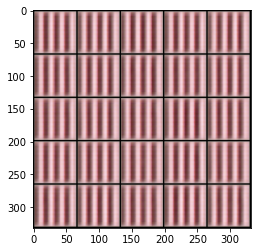

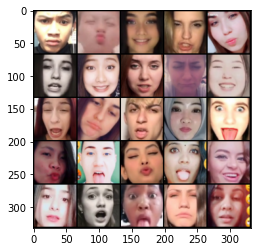

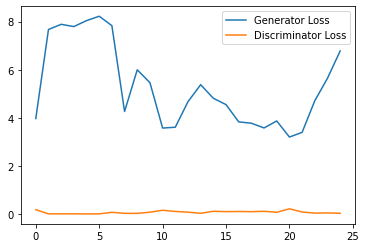

Step 1000: Generator loss: 5.299494267225265, discriminator loss: 0.12264691410202068


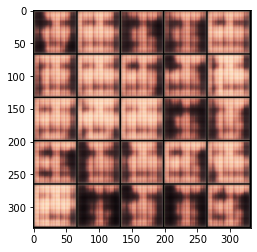

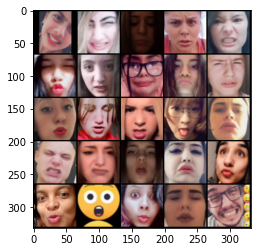

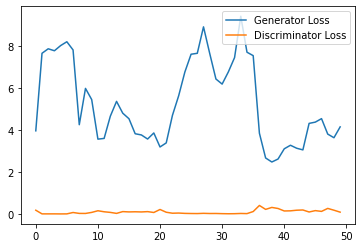

  0%|          | 0/1189 [00:00<?, ?it/s]

Step 1500: Generator loss: 3.5922438623905184, discriminator loss: 0.19376111862063408


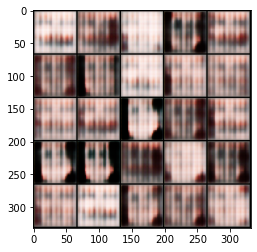

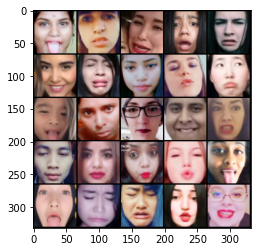

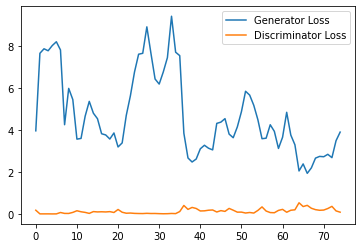

Step 2000: Generator loss: 2.6031121619939803, discriminator loss: 0.2827816164940596


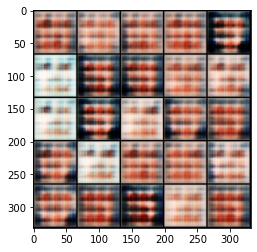

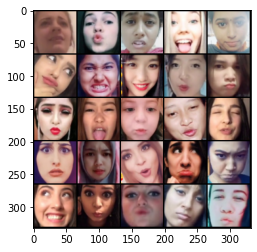

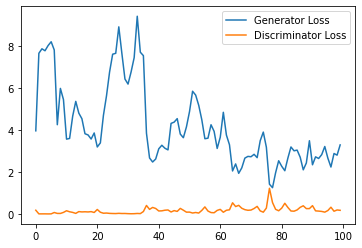

  0%|          | 0/1189 [00:00<?, ?it/s]

Step 2500: Generator loss: 3.4954947209358216, discriminator loss: 0.22238230504095555


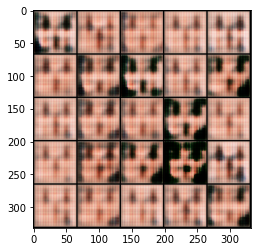

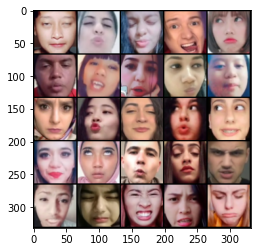

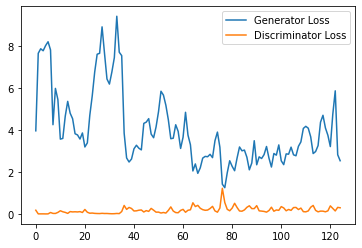

Step 3000: Generator loss: 2.7974368917942045, discriminator loss: 0.2553538837842643


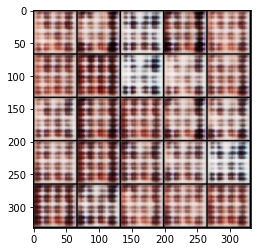

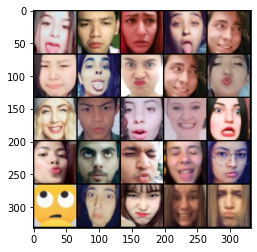

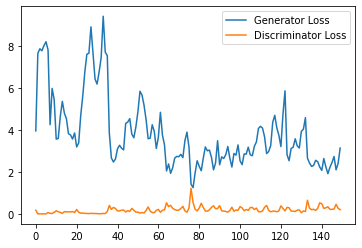

Step 3500: Generator loss: 2.7746047999858856, discriminator loss: 0.287955168440938


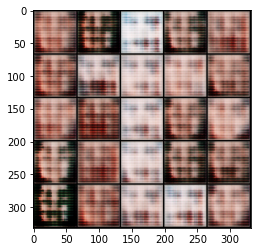

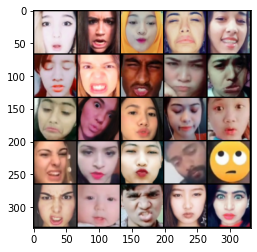

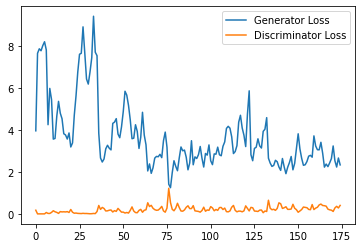

  0%|          | 0/1189 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.3926370153427126, discriminator loss: 0.3033054447770119


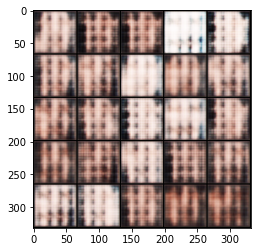

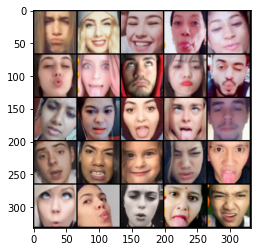

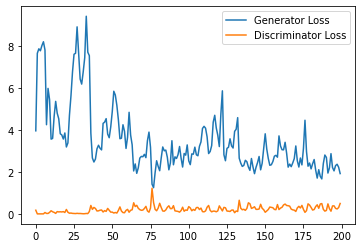

Step 4500: Generator loss: 2.229995728492737, discriminator loss: 0.33315126080811025


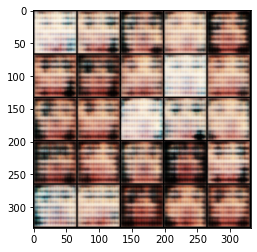

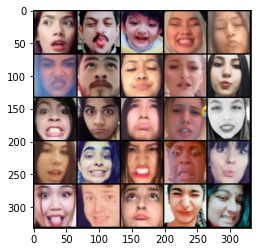

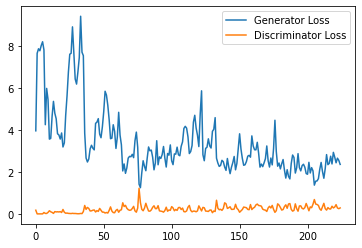

  0%|          | 0/1189 [00:00<?, ?it/s]

In [ ]:
train(n_epochs, dataloader, gen, gen_opt, disc, disc_opt, criterion)

In [ ]:
# Adapted from https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee
def load_ckpt(checkpoint_path, gen, gen_opt, disc, disc_opt):
    # load checkpoint
    checkpoint = torch.load(checkpoint_path)
    
    # initialize state_dict from checkpoint
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc.load_state_dict(checkpoint['disc_state_dict'])
    
    # initialize optimizers from checkpoint
    gen_opt.load_state_dict(checkpoint['gen_opt'])
    disc_opt.load_state_dict(checkpoint['disc_opt'])
    
    return checkpoint['epoch'], gen, disc, gen_opt, disc_opt

## Exploration
You can do a bit of exploration now!

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [22]:
# Before you explore, you should put the generator
# in eval mode, both in general and so that batch norm
# doesn't cause you issues and is using its eval statistics
gen = gen.eval()

#### Changing the Class Vector
You can generate some numbers with your new model! You can add interpolation as well to make it more interesting.

So starting from a image, you will produce intermediate images that look more and more like the ending image until you get to the final image. Your're basically morphing one image into another. You can choose what these two images will be using your conditional GAN.

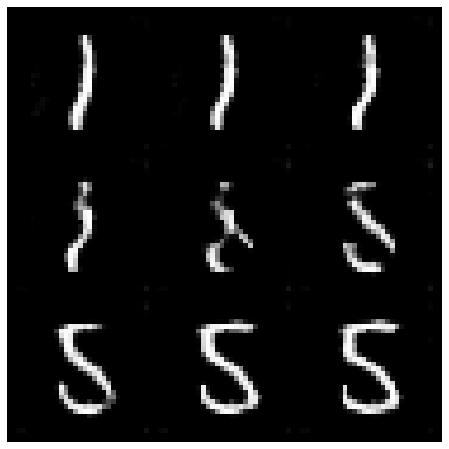

In [23]:
import math

### Change me! ###
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

### Change me! ###
start_plot_number = 1 # Choose the start digit
### Change me! ###
end_plot_number = 5 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

### Uncomment the following lines of code if you would like to visualize a set of pairwise class 
### interpolations for a collection of different numbers, all in a single grid of interpolations.
### You'll also see another visualization like this in the next code block!
# plot_numbers = [2, 3, 4, 5, 7]
# n_numbers = len(plot_numbers)
# plt.figure(figsize=(8, 8))
# for i, first_plot_number in enumerate(plot_numbers):
#     for j, second_plot_number in enumerate(plot_numbers):
#         plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
#         interpolate_class(first_plot_number, second_plot_number)
#         plt.axis('off')
# plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
# plt.show()
# plt.close()

#### Changing the Noise Vector
Now, what happens if you hold the class constant, but instead you change the noise vector? You can also interpolate the noise vector and generate an image at each step.

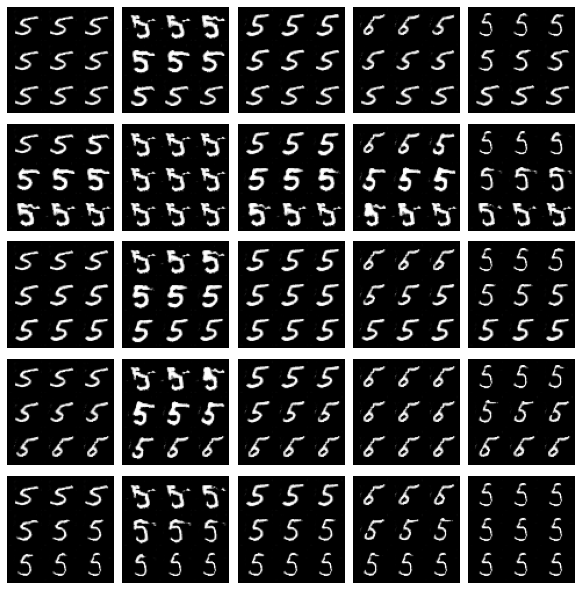

In [24]:
n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
### Change me! ###
n_noise = 5 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()